In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 120

np.random.seed(0)

import tqdm
from elman import ElmanNetwork, normalize

In [6]:
circleData = np.genfromtxt('data/mouse_circle_data.csv', delimiter=',')
figureEightData = np.genfromtxt('data/mouse_figure_eight_data.csv', delimiter=',')

dsFactor = 4

# Put circle into bottom left
circleXArr = normalize(circleData[::dsFactor,0]) / 2
circleYArr = normalize(circleData[::dsFactor,1]) / 2

# Put figure eight into top right

feXArr = normalize(figureEightData[::dsFactor,0]) / 2 + .4
feYArr = normalize(figureEightData[::dsFactor,1]) / 2 + .4

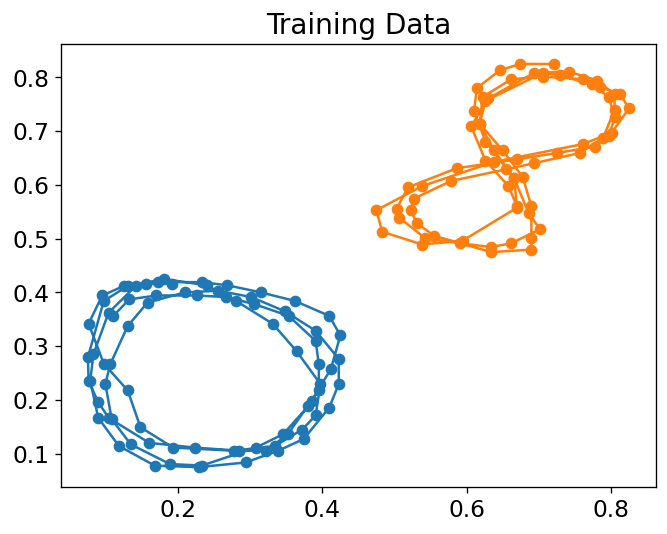

In [7]:
plt.plot(circleXArr, circleYArr, '-o')
plt.plot(feXArr, feYArr, '-o')
plt.title('Training Data')
plt.show()

In [ ]:
numEpochs = 15000

model = ElmanNetwork(loadPath='models/multi_attractor.npz')

inputArr = np.array(list(zip(xArr, yArr)))[:-1]
targetArr = np.array(list(zip(xArr, yArr)))[1:]
contextArr, outputArr = model.forwardSequence(inputArr)

errorArr = np.zeros(numEpochs) # list to store errors

In [44]:
numEpochs = 50000
circleFigureEightTrainingSplit = .3 # .2 means 20% circle, 80% figure eight
noiseStrength = .01

model = ElmanNetwork(inputDim=2,
                     contextDim=30,
                     outputDim=2,
                     learningRate=.1)

circleInputArr = np.array(list(zip(circleXArr, circleYArr)))[:-1]
circleTargetArr = np.array(list(zip(circleXArr, circleYArr)))[1:]

feInputArr = np.array(list(zip(feXArr, feYArr)))[:-1]
feTargetArr = np.array(list(zip(feXArr, feYArr)))[1:]

inputArr = [circleInputArr, feInputArr]
targetArr = [circleTargetArr, feTargetArr]

errorArr = np.zeros(numEpochs) # list to store errors

trainingOrder = [0]*int(numEpochs*circleFigureEightTrainingSplit) + [1]*int(numEpochs*(1 - circleFigureEightTrainingSplit))
np.random.shuffle(trainingOrder)

for epoch in tqdm.tqdm(range(numEpochs)):    
    # Context and output
    noiseArr = np.random.normal(0, noiseStrength, size=inputArr[trainingOrder[epoch]].shape)
    
    contextArr, outputArr = model.forwardSequence(inputArr[trainingOrder[epoch]] + noiseArr)
    errorArr[epoch]  = model.backwardSequence(inputArr[trainingOrder[epoch]] + noiseArr,
                                              contextArr, outputArr, targetArr[trainingOrder[epoch]])
    model.updateParameters()
    
model.save('models/multi_attractor.npz')

100%|████████████████████| 50000/50000 [02:15<00:00, 368.04it/s]


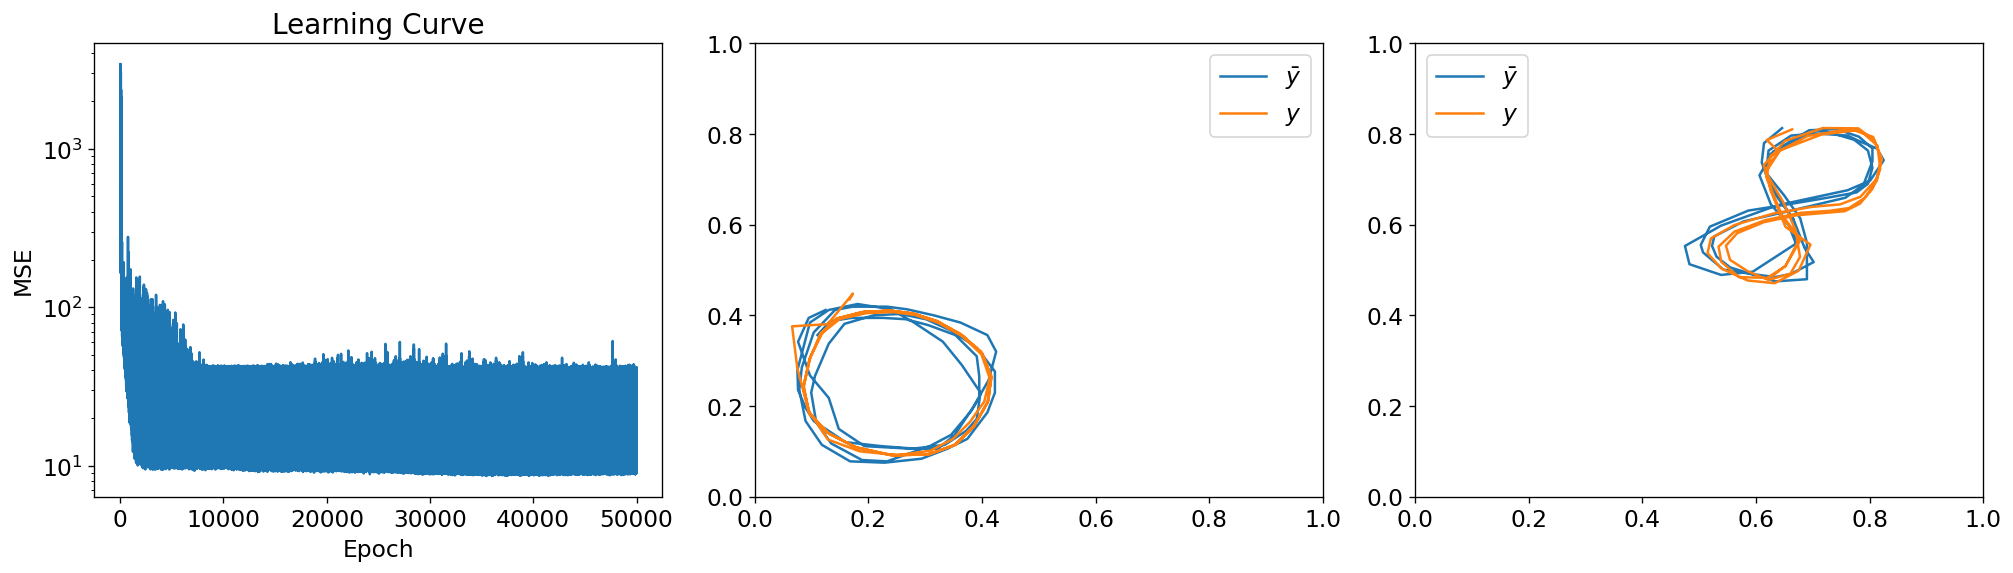

In [45]:
fig = plt.figure(figsize=(17,5))

ax = [None, None, None]
ax[0] = fig.add_subplot(1, 3, 1)

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1] = fig.add_subplot(1, 3, 2)

circleOutputArr = model.predict([circleXArr[0], circleYArr[1]], predictionSteps=circleXArr.shape[0])

ax[1].plot(targetArr[0][1:,0], targetArr[0][1:,1], label=r'$\bar y$')
ax[1].plot(circleOutputArr[1:,0], circleOutputArr[1:,1], label=r'$y$')
ax[1].legend()
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])

ax[2] = fig.add_subplot(1, 3, 3)

feOutputArr = model.predict([feXArr[0], feYArr[1]], predictionSteps=feXArr.shape[0])

ax[2].plot(targetArr[1][1:,0], targetArr[1][1:,1], label=r'$\bar y$')
ax[2].plot(feOutputArr[1:,0], feOutputArr[1:,1], label=r'$y$')
ax[2].legend()
ax[2].set_xlim([0,1])
ax[2].set_ylim([0,1])

fig.tight_layout()

plt.show()

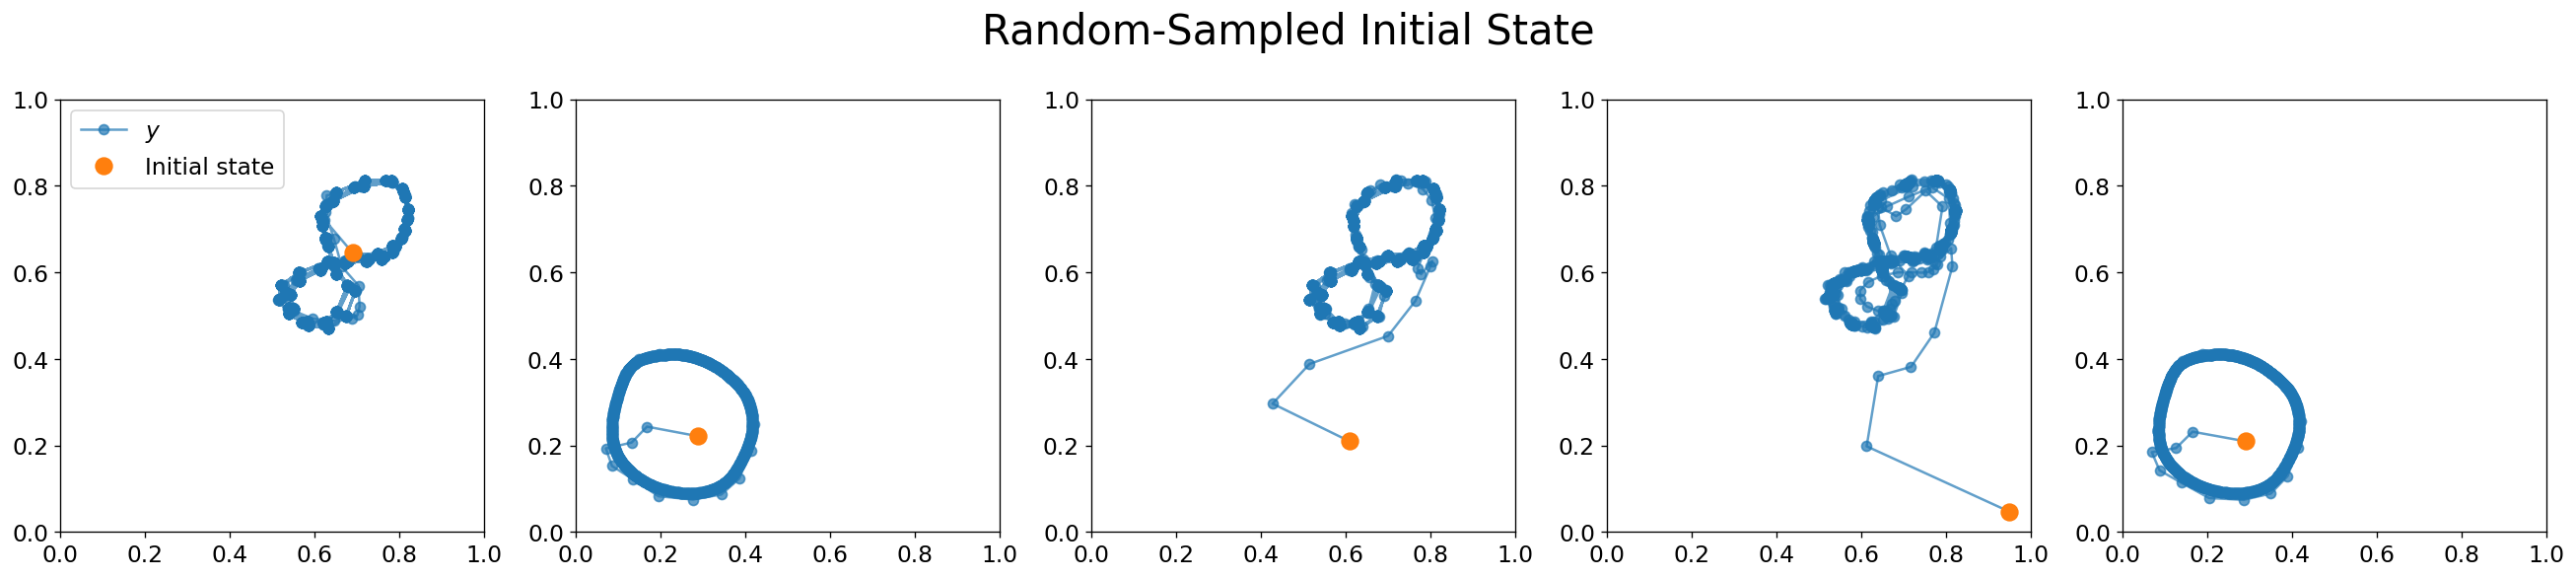

In [47]:
fig, ax = plt.subplots(1, 5, figsize=(22,5))

initialPoints = np.random.uniform(0, 1, size=(5,2))

for i in range(5):

    nSteps = 1000

    predictArr = model.predict(initialPoints[i], predictionSteps=nSteps)
    
    ax[i].plot(predictArr[:,0], predictArr[:,1], '-o', alpha=.7, label='$ y $')
    ax[i].plot(initialPoints[i][0], initialPoints[i][1], 'o', markersize=10, label='Initial state')

    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([0, 1])

ax[0].legend()
fig.suptitle('Random-Sampled Initial State', fontsize=25)
fig.tight_layout()
plt.show()

## Phase Plot

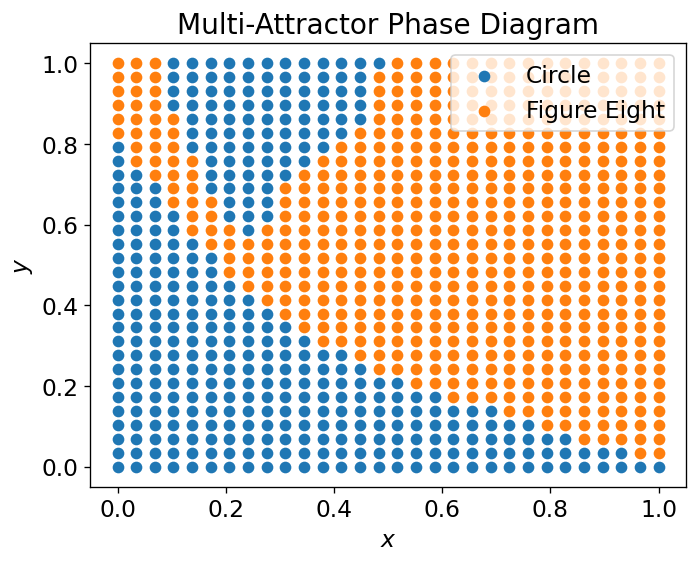

Ratio of area in phase diagram: circle/total = 0.402
Ratio of area in phase diagram: figure eight/total = 0.598


In [73]:
testXArr = np.linspace(0, 1, 30)
testYArr = np.linspace(0, 1, 30)
nSteps = 500

phaseArr = np.zeros((len(testXArr), len(testYArr)))

for i in range(len(testXArr)):
    for j in range(len(testYArr)):

        predictArr = model.predict([testXArr[i], testYArr[j]], predictionSteps=nSteps)
        
        # Take average of last 100
        averagePosition = np.mean(predictArr[-100:], axis=0)
        
        # If average position is around .25, .25, then it is a circle (0)
        # If average position is around .75, .75, then it is a figure eight (1)
        # Otherwise, something weird happened (2)
        if np.sqrt(np.sum((averagePosition - np.array([.25, .25]))**2)) < .15:
            phaseArr[i,j] = 0
        elif np.sqrt(np.sum((averagePosition - np.array([.75, .75]))**2)) < .15:
            phaseArr[i,j] = 1
        else:
            phaseArr[i,j] = 2
            
plt.scatter(testXArr[np.where(phaseArr == 0)[0]], testYArr[np.where(phaseArr == 0)[1]], label='Circle')
plt.scatter(testXArr[np.where(phaseArr == 1)[0]], testYArr[np.where(phaseArr == 1)[1]], label='Figure Eight')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Multi-Attractor Phase Diagram')
plt.show()

values, counts = np.unique(phaseArr, return_counts=True)
print(f'Ratio of area in phase diagram: circle/total = {counts[values == 0][0] / np.sum(counts):.3}')
print(f'Ratio of area in phase diagram: figure eight/total = {counts[values == 1][0] / np.sum(counts):.3}')

## Attractor Bias Based on Training Split

In [86]:
numEpochs = 25000
# eg. .2 means 20% circle, 80% figure eight
circleFigureEightTrainingSplitArr = np.linspace(0.1, .9, 10)
noiseStrength = .01

biasArr = np.zeros_like(circleFigureEightTrainingSplitArr)

circleInputArr = np.array(list(zip(circleXArr, circleYArr)))[:-1]
circleTargetArr = np.array(list(zip(circleXArr, circleYArr)))[1:]

feInputArr = np.array(list(zip(feXArr, feYArr)))[:-1]
feTargetArr = np.array(list(zip(feXArr, feYArr)))[1:]

inputArr = [circleInputArr, feInputArr]
targetArr = [circleTargetArr, feTargetArr]

for i in tqdm.tqdm(range(len(circleFigureEightTrainingSplitArr)), position=0):
    split = circleFigureEightTrainingSplitArr[i]
    
    model = ElmanNetwork(inputDim=2,
                         contextDim=30,
                         outputDim=2,
                         learningRate=.1)

    errorArr = np.zeros(numEpochs) # list to store errors

    # Ceil and floor to make sure the sum is always equal to numEpochs exactly
    trainingOrder = [0]*int(np.ceil(numEpochs*split)) + [1]*int(np.floor(numEpochs*(1 - split)))
    if len(trainingOrder) < numEpochs:
        trainingOrder += [0]* (numEpochs - len(trainingOrder))
        
    np.random.shuffle(trainingOrder)

    for epoch in range(numEpochs):
        # Generate some random noise to add to the input
        noiseArr = np.random.normal(0, noiseStrength, size=inputArr[trainingOrder[epoch]].shape)
        
        # Context and output
        contextArr, outputArr = model.forwardSequence(inputArr[trainingOrder[epoch]] + noiseArr)
        errorArr[epoch]  = model.backwardSequence(inputArr[trainingOrder[epoch]] + noiseArr,
                                                  contextArr, outputArr, targetArr[trainingOrder[epoch]])
        model.updateParameters()

    model.save(f'models/multi_attractor_{split:.2}_split.npz')

    testXArr = np.linspace(0, 1, 30)
    testYArr = np.linspace(0, 1, 30)
    nSteps = 500

    phaseArr = np.zeros((len(testXArr), len(testYArr)))

    for j in range(len(testXArr)):
        for k in range(len(testYArr)):

            predictArr = model.predict([testXArr[j], testYArr[k]], predictionSteps=nSteps)

            # Take average of last 100
            averagePosition = np.mean(predictArr[-100:], axis=0)

            # If average position is around .25, .25, then it is a circle (0)
            # If average position is around .75, .75, then it is a figure eight (1)
            # Otherwise, something weird happened (2)
            if np.sqrt(np.sum((averagePosition - np.array([.25, .25]))**2)) < .15:
                phaseArr[j,k] = 0
            elif np.sqrt(np.sum((averagePosition - np.array([.75, .75]))**2)) < .15:
                phaseArr[j,k] = 1
            else:
                phaseArr[j,k] = 2

    values, counts = np.unique(phaseArr, return_counts=True)
    
    biasArr[i] = counts[values == 0][0] / np.sum(counts) if len(counts[values == 0]) > 0 else 0

100%|███████████████████████████| 10/10 [12:18<00:00, 73.81s/it]


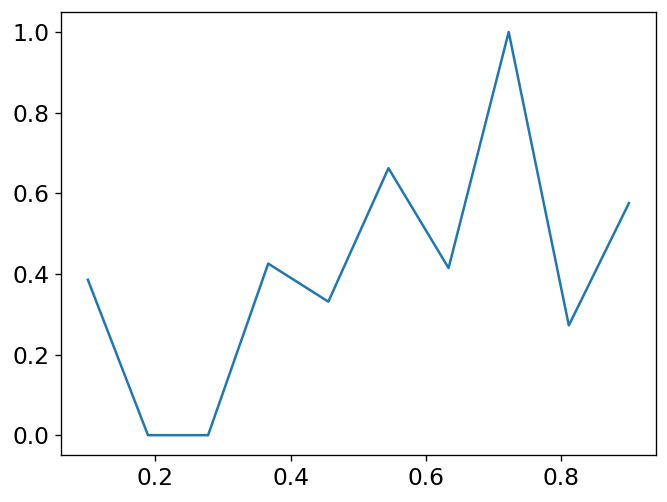

In [87]:
plt.plot(circleFigureEightTrainingSplitArr, biasArr)
plt.show()

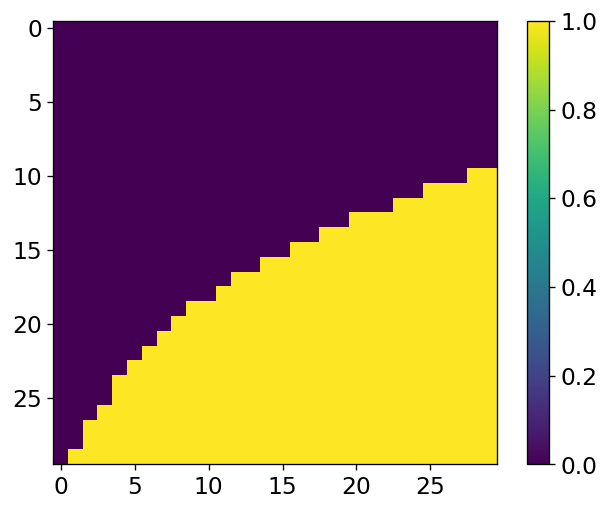

In [89]:
plt.imshow(phaseArr)
plt.colorbar()
plt.show()